In [1]:
# Uncomment this command to install the necessary libraries, versions listed are the ones used in this notebook

# !pip install -r requirements.txt

In [1]:
# Import necessary libraries

## File and path tools
import glob

## Arrays and dataframes
import numpy as np
import pandas as pd

## Image loading, processing and analysis
import skimage.io as skio
from skimage.measure import regionprops_table
from scipy import ndimage as ndi
from scipy.ndimage import label, generate_binary_structure

## Data visualization
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Start of image analysis

# We first generate a "binary structure" that helps group pixels as members of the object
# Here we group them based on horizontal, vertical and diagonal connection. 
# For that, we generate a binary structure of connections
s = generate_binary_structure(2,2)

# We create an empty list where our data will be stored
df_list = []

# Here we work with segmentation results of phase gray and phase bright spores

# We list all the segmentation files and list them to be read
mask_path = r'/Users/reyesmatte/Downloads/Iqra_TLapses/Segmentation/*'
    
masks = np.sort(glob.glob(mask_path))
    
# Now we iterate through all the images
    
for mm in masks:
    
# First we construct a labeled mask, where each object has an individual index
    labeled_mask = label( # Labeling of the masks
        ndi.binary_erosion( # Erode the masks to remove remaining "loose" pixels
            ndi.binary_fill_holes( # Fill the small holes in the masks
                ndi.binary_erosion( # Erode the masks to remove "loose" pixels
                    skio.imread(mm) > 1))).astype(int), # Here we read the image and binarize it from the Ilastik segmentation result
        structure=s # Use our binary structure to connect the objects
    )[0] # Only the first element of the label function is the labeled mask
    
    # Calculate the spore number
    SporeNum = np.sum( # A sum of all resulting objects that fulfill the area threshold
        regionprops_table( # Generate an array that will have the area values
            labeled_mask, properties=('area','centroid'))['area'] > 10) # Then filter the area values being greater than ten square pixels
    
    df_dict = {"Strain":mm.split("/")[-1].split("_")[0],
                 "Time":int(mm.split("/")[-1].split("_")[1]),
                 "SporeNumber":SporeNum}
    
    df_list.append(pd.DataFrame(df_dict, index=[0]))
    

final_df = pd.concat(df_list,ignore_index=True)

In [16]:
np.unique(final_df.Strain)

strains = ['PY79','JLG4003', 'JLG5146', 'JLG5149']

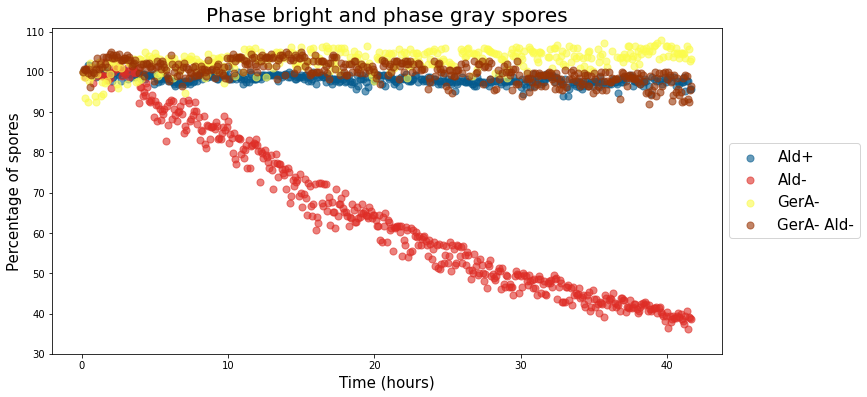

In [26]:
# Plot the data

# Define figure size
plt.figure(figsize=(12,6))

# Obtain the number of spores at the initial time point
T0s = final_df[(final_df.Time == 1)]

# Iterate through the strains
for ss in strains:
    
    # We define different colors and markers for the points in the plot according to the strain
    
    if ss == 'JLG4003':
        s2 = "Ald-"
        Color = '#de2d26'
        
    elif ss == 'JLG5146':
        s2 = "GerA-"
        Color = '#fbfb4b'
        
    elif ss == 'JLG5149':
        s2 = "GerA- Ald-"
        Color = '#993404'
        
    else:
        s2 = "Ald+"
        Color = '#045a8d'
    
    # Make a subset of the dataframe containing only the spores
    subdf = final_df[final_df.Strain == ss]
    
    # Get the values at the initial time point
    T0_spores = int(T0s[T0s.Strain == ss].SporeNumber.values)
    
    # Plot the data
    ax = plt.scatter( # Scatterplot
        subdf.Time/12, # Time transformed to hours
        100*subdf.SporeNumber/T0_spores,# Percentage of spores
        label=s2,# Legend label
        c=Color, # Plot point color
        alpha=.6,
    s=50)

# Complete the plot information
plt.title("Phase bright and phase gray spores",size=20)
plt.xlabel("Time (hours)",size=15)
plt.ylabel("Percentage of spores",size=15)
plt.xticks(size=10)
plt.yticks(size=10) 
plt.ylim(bottom=30,top=111) # Y axis limits
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)